# Análise para departamento de relações públicas
Objetivo: Identificar comentários positivos e negativos sobre um produto
## Carga de dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import string
import pickle

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/daniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
reviews_df = pd.read_csv("./amazon_alexa.tsv", sep="\t")

reviews_df

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1


feedback: 1 (Avaliação positiva), 0 (Avaliação negativa) <br>
rating: >=4 (feedback=1), <4 (feedback=0) <br>
date: Data da avaliação <br>
variation: Nome do produto avaliado <br>
verified_reviews: Comentário

## Análise dos dados

In [3]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [4]:
reviews_df.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


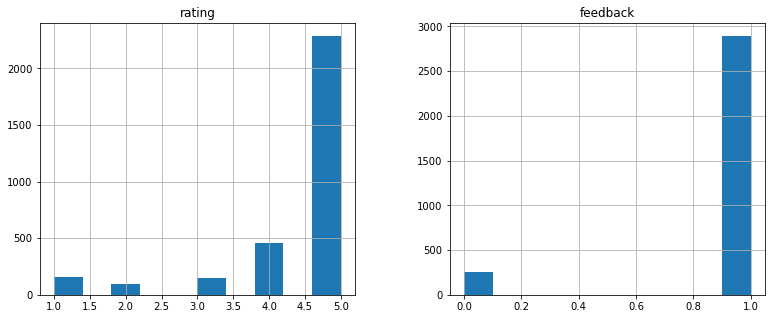

In [5]:
reviews_df.hist(bins=10, figsize=(13, 5));

In [6]:
reviews_df['length'] = reviews_df['verified_reviews'].apply(lambda x: len(x))

reviews_df

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5
...,...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1,50
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1,135
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1,441
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1,380


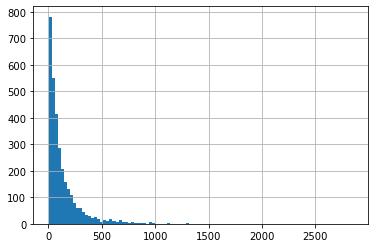

In [7]:
reviews_df['length'].hist(bins=100);

In [8]:
reviews_df['length'].describe()

count    3150.000000
mean      132.049524
std       182.099952
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: length, dtype: float64

In [9]:
reviews_df.query(f'length == {reviews_df.length.max()}')

,rating,date,variation,verified_reviews,feedback,length
2016,5,20-Jul-18,Black Plus,Incredible piece of technology.I have this rig...,1,2851


In [10]:
reviews_df.query(f'length == {reviews_df.length.min()}')

,rating,date,variation,verified_reviews,feedback,length
60,5,30-Jul-18,Heather Gray Fabric,😍,1,1
85,5,30-Jul-18,Heather Gray Fabric,,1,1
183,3,29-Jul-18,Heather Gray Fabric,,1,1
219,5,29-Jul-18,Sandstone Fabric,,1,1
374,1,26-Jul-18,Black,,0,1
...,...,...,...,...,...,...
3114,3,30-Jul-18,Black Dot,,1,1
3120,5,30-Jul-18,Black Dot,,1,1
3123,4,30-Jul-18,Black Dot,,1,1
3126,5,30-Jul-18,Black Dot,,1,1


In [11]:
reviews_df.query(f'length == {int(reviews_df.length.mean())}')

,rating,date,variation,verified_reviews,feedback,length
570,4,11-Jun-18,Black,Nice. It works good.Some times is not easy to ...,1,132
1655,5,28-Jul-18,White Show,awesome product! I am in the process of having...,1,132
1705,3,28-Jul-18,Black Show,"If you belong to amazon prime, I would think t...",1,132
2321,4,30-Jul-18,Configuration: Fire TV Stick,I expected to have access to more current movi...,1,132
2483,4,30-Jul-18,White Dot,Works good for the most part. You ask it some ...,1,132
2834,4,30-Jul-18,White Dot,Works good for the most part. You ask it some ...,1,132


Comparando reviews positivos e negativos

In [12]:
positive = reviews_df.query("feedback == 1")

positive.describe()

,rating,feedback,length
count,2893.000000,2893.0,2893.000000
mean,4.737643,1.0,124.659177
std,0.546544,0.0,174.624491
min,3.000000,1.0,1.000000
25%,5.000000,1.0,29.000000
50%,5.000000,1.0,69.000000
75%,5.000000,1.0,154.000000
max,5.000000,1.0,2851.000000


In [13]:
negative = reviews_df.query("feedback == 0")

negative.describe()

,rating,feedback,length
count,257.000000,257.0,257.000000
mean,1.373541,0.0,215.241245
std,0.484688,0.0,236.325955
min,1.000000,0.0,1.000000
25%,1.000000,0.0,53.000000
50%,1.000000,0.0,137.000000
75%,2.000000,0.0,289.000000
max,2.000000,0.0,1686.000000


/home/daniel/miniconda3/envs/dissertacao/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


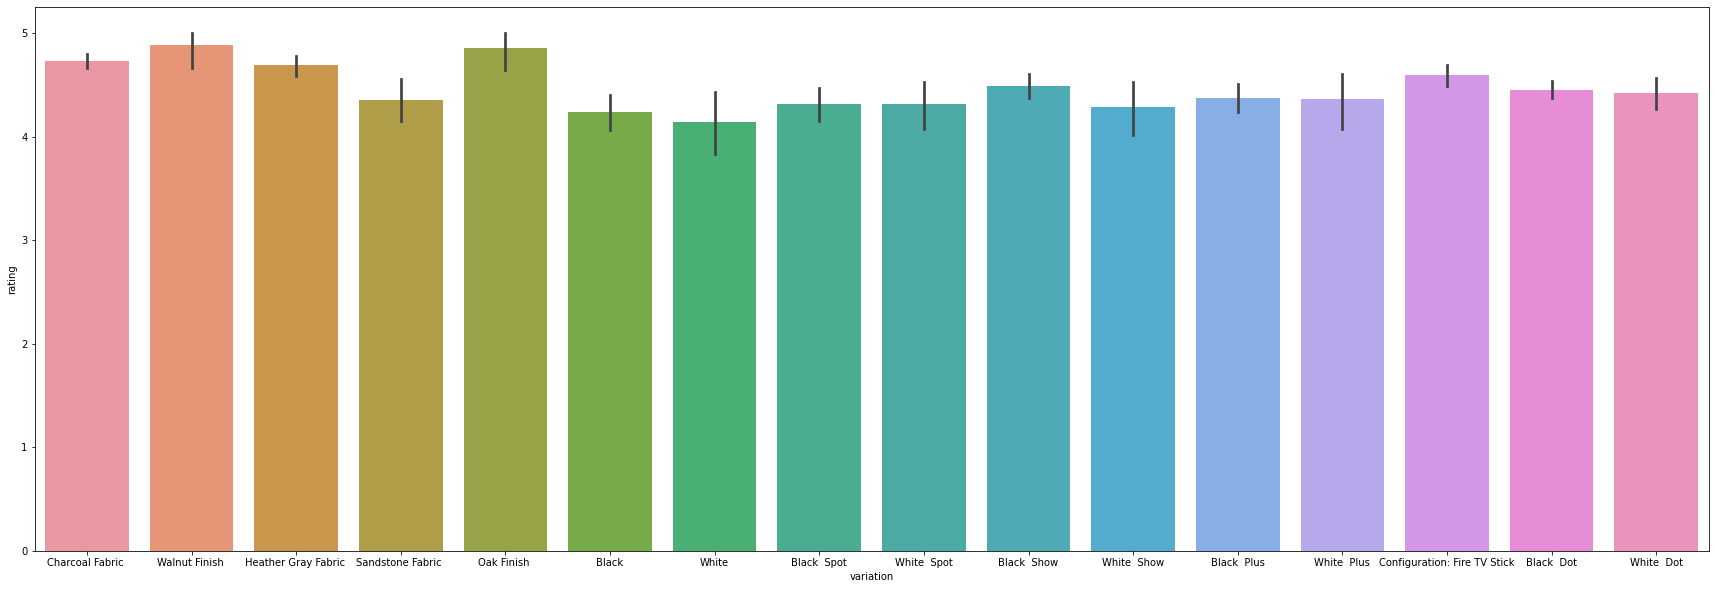

In [14]:
plt.figure(figsize=(30, 10))
sns.barplot(reviews_df.variation, reviews_df.rating);

Identificando palavras mais frequentes

In [15]:
sentenses = reviews_df.verified_reviews
sentenses

0                                           Love my Echo!
1                                               Loved it!
2       Sometimes while playing a game, you can answer...
3       I have had a lot of fun with this thing. My 4 ...
4                                                   Music
                              ...                        
3145    Perfect for kids, adults and everyone in betwe...
3146    Listening to music, searching locations, check...
3147    I do love these things, i have them running my...
3148    Only complaint I have is that the sound qualit...
3149                                                 Good
Name: verified_reviews, Length: 3150, dtype: object

In [16]:
one_string_sentence = " ".join(sentenses)
one_string_sentence

'Love my Echo! Loved it! Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home. I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well. Music I received the echo as a gift. I needed another Bluetooth or something to play music easily accessible, and found this smart speaker. Can’t wait to see what else it can do. Without having a cellphone, I cannot use many of her features. I have an iPad but do not see that of any use.  It IS a great alarm.  If u r almost deaf, you can hear her alarm in the bedroom from out in the living room, so that is reason enough to keep her.It is fun to ask random questions to hear her response.  She does not seem to be very smartbon politics yet. I think this is the 5th one I\'ve purchased. I\'m working on 

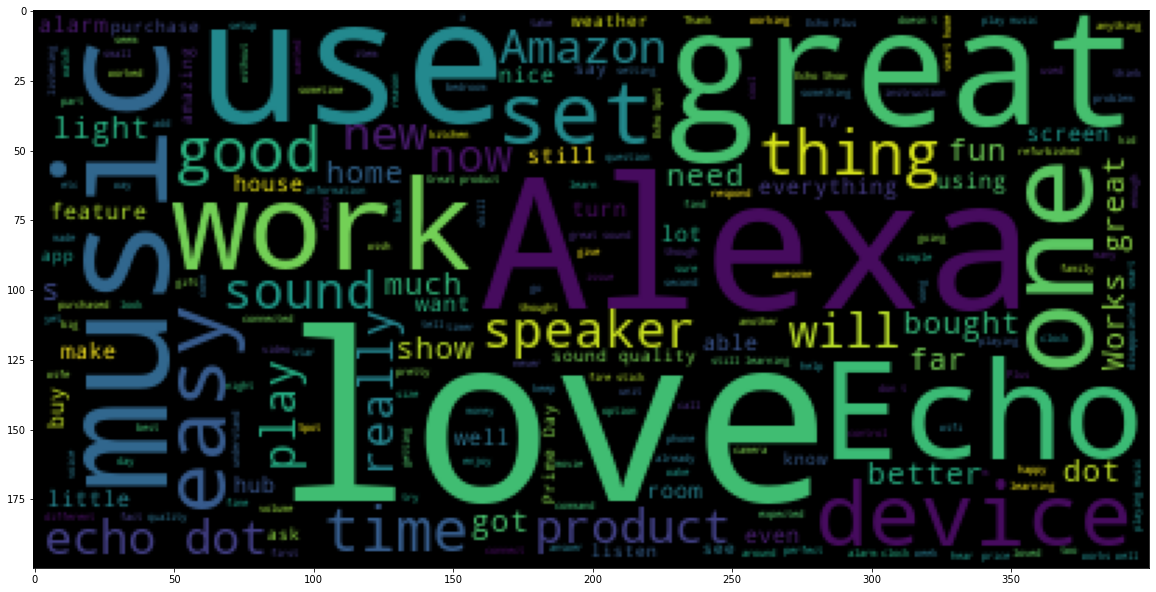

In [17]:
plt.figure(figsize=(20, 20))
plt.imshow(WordCloud().generate(one_string_sentence))

Identificando palavras negativas mais frequentes

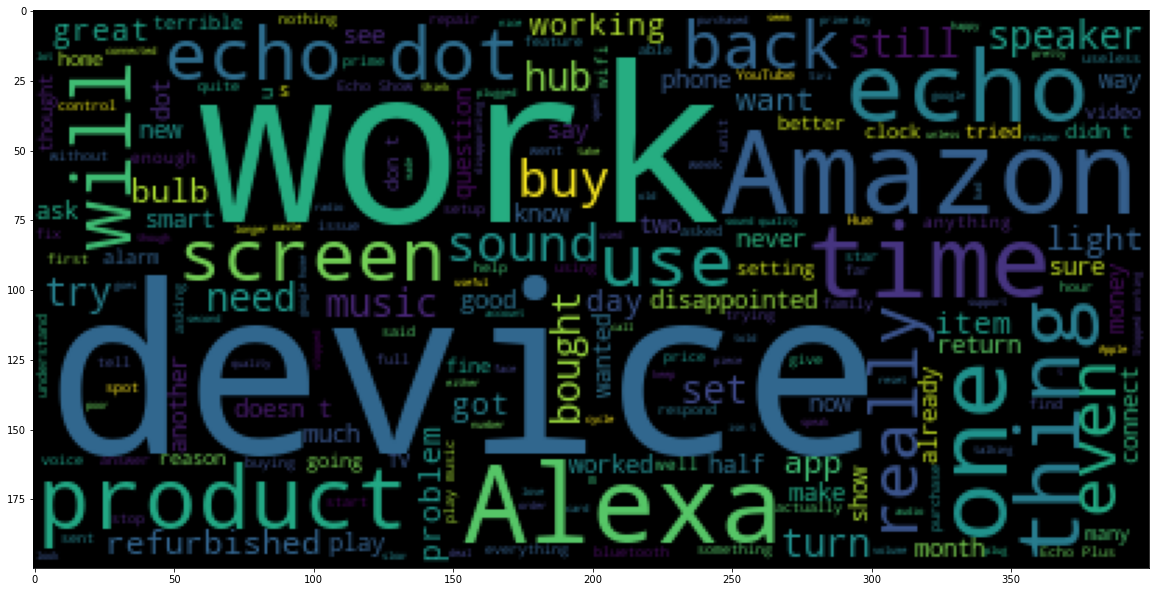

In [18]:
negative_list = negative.verified_reviews
one_string_sentence_nagative = " ".join(negative_list)

plt.figure(figsize=(20, 20))
plt.imshow(WordCloud().generate(one_string_sentence_nagative));

## Tratamento de dados

In [19]:
reviews_df.drop(columns=["date", "rating", "length"], inplace=True)#, "variation"
reviews_df

,variation,verified_reviews,feedback
0,Charcoal Fabric,Love my Echo!,1
1,Charcoal Fabric,Loved it!,1
2,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,Charcoal Fabric,Music,1
...,...,...,...
3145,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,Black Dot,"Listening to music, searching locations, check...",1
3147,Black Dot,"I do love these things, i have them running my...",1
3148,White Dot,Only complaint I have is that the sound qualit...,1


### Convertendo o tipo de produto (variável categórica) pra variável numérica

In [20]:
x_cat = reviews_df[['variation']]

encoder = OneHotEncoder()
x_cat = encoder.fit_transform(x_cat).toarray()

x_cat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [21]:
x_cat = pd.DataFrame(x_cat)
x_cat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3146,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3147,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [22]:
reviews_df.drop(columns=["variation"], inplace=True)
reviews_df

,verified_reviews,feedback
0,Love my Echo!,1
1,Loved it!,1
2,"Sometimes while playing a game, you can answer...",1
3,I have had a lot of fun with this thing. My 4 ...,1
4,Music,1
...,...,...
3145,"Perfect for kids, adults and everyone in betwe...",1
3146,"Listening to music, searching locations, check...",1
3147,"I do love these things, i have them running my...",1
3148,Only complaint I have is that the sound qualit...,1


In [23]:
reviews_df = pd.concat([reviews_df, x_cat], axis=1)
reviews_df

,verified_reviews,feedback,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Love my Echo!,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Loved it!,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Sometimes while playing a game, you can answer...",1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,I have had a lot of fun with this thing. My 4 ...,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Music,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,"Perfect for kids, adults and everyone in betwe...",1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3146,"Listening to music, searching locations, check...",1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3147,"I do love these things, i have them running my...",1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3148,Only complaint I have is that the sound qualit...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Tratamento de texto
Remoção de digitos e stopwords 

In [24]:
def message_cleaning(message: str):
    text = [char for char in message if char not in string.punctuation and not char.isdigit()]
    text = ''.join(text)
    text = [word.lower() for word in text.split() if word.lower() not in stopwords.words("english")]
    
    return text

#### Transformando texto em vetor de caracteristicas

In [25]:
#o processo abaixo faz isso também -> reviws_df_clean = reviews_df['verified_reviews'].apply(message_cleaning)
vectorizer = CountVectorizer(analyzer=message_cleaning)
reviwers_count_vectorized = vectorizer.fit_transform(reviews_df['verified_reviews'])

In [26]:
print(vectorizer.get_feature_names())

['abay', 'abc', 'abd', 'abilities', 'ability', 'able', 'abode', 'absolutely', 'absolutly', 'ac', 'accent', 'accentthe', 'acceptable', 'accepting', 'access', 'accessable', 'accessible', 'accessing', 'accessneeds', 'accessories', 'accesss', 'accessto', 'accident', 'accidentally', 'accompanying', 'accomplish', 'accomplished', 'according', 'accordingly', 'account', 'accounts', 'accuracy', 'accurate', 'accurately', 'accustom', 'acknowledge', 'acoustical', 'across', 'act', 'acting', 'action', 'actions', 'activate', 'activated', 'activates', 'activating', 'activation', 'actively', 'activities', 'acts', 'actually', 'ad', 'adapted', 'adapter', 'adapting', 'add', 'added', 'addict', 'addicted', 'addicts', 'adding', 'addition', 'additional', 'additionally', 'addons', 'addressed', 'addresses', 'adds', 'adept', 'adequate', 'adjacent', 'adjust', 'adjusting', 'adjustment', 'adjusts', 'admit', 'adopters', 'adorable', 'ads', 'adults', 'advance', 'advanced', 'advantage', 'advantages', 'advertise', 'adver

/home/daniel/miniconda3/envs/dissertacao/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [27]:
reviwers_count_vectorized.shape

(3150, 4318)

In [28]:
reviews_df.drop(columns=["verified_reviews"], inplace=True)

reviews = pd.DataFrame(reviwers_count_vectorized.toarray())
reviews_df = pd.concat([reviews_df, reviews], axis=1)
reviews_df

,feedback,0,1,2,3,4,5,6,7,8,...,4308,4309,4310,4311,4312,4313,4314,4315,4316,4317
0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3146,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3147,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3148,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Treinamento do modelo

### Separação do dado de treino e de teste

In [108]:
x = reviews_df.drop(columns=["feedback"])
y = reviews_df["feedback"]

In [109]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.9, shuffle=True)
x_train.shape, x_test.shape

((2835, 4334), (315, 4334))

### Execução do modelo Naive Bayes

In [110]:
naive_bayes = MultinomialNB()
naive_bayes.fit(x_train, y_train);

#### Validação do modelo

In [111]:
y_pred = naive_bayes.predict(x_test)
accuracy_score(y_test, y_pred)

0.9079365079365079

<AxesSubplot:>

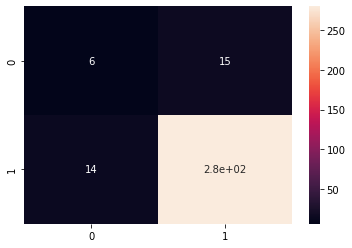

In [112]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

In [113]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.30      0.29      0.29        21
           1       0.95      0.95      0.95       294

    accuracy                           0.91       315
   macro avg       0.62      0.62      0.62       315
weighted avg       0.91      0.91      0.91       315



Média do macro avg após 10 execuções separando o dado de forma aleatória: 0.72

### Execução do modelo de Regressão Logistica

In [114]:
logistic = LogisticRegression()
logistic.fit(x_train, y_train);

#### Validação do modelo

In [115]:
y_pred = logistic.predict(x_test)
accuracy_score(y_test, y_pred)

0.9428571428571428

<AxesSubplot:>

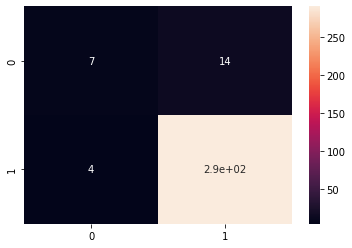

In [116]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

In [117]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.33      0.44        21
           1       0.95      0.99      0.97       294

    accuracy                           0.94       315
   macro avg       0.80      0.66      0.70       315
weighted avg       0.93      0.94      0.93       315



Média do macro avg após 10 execuções separando o dado de forma aleatória: 0.75

## Salvando o melhor classificador

In [ ]:
with open("text_classifier.pkl", "wb") as f:
    pickle.dump([logistic, encoder, vectorizer], f)

## Simulando o uso do modelo em produção
### Carga do modelo

In [128]:
with open("text_classifier.pkl", "rb") as f:
    model, enc, vec = pickle.load(f)

Comentário aleatório a ser analisado

In [129]:
negative

,rating,date,variation,verified_reviews,feedback,length
46,2,30-Jul-18,Charcoal Fabric,"It's like Siri, in fact, Siri answers more acc...",0,163
111,2,30-Jul-18,Charcoal Fabric,Sound is terrible if u want good music too get...,0,53
141,1,30-Jul-18,Charcoal Fabric,Not much features.,0,18
162,1,30-Jul-18,Sandstone Fabric,"Stopped working after 2 weeks ,didn't follow c...",0,87
176,2,30-Jul-18,Heather Gray Fabric,Sad joke. Worthless.,0,20
...,...,...,...,...,...,...
3047,1,30-Jul-18,Black Dot,Echo Dot responds to us when we aren't even ta...,0,120
3048,1,30-Jul-18,White Dot,NOT CONNECTED TO MY PHONE PLAYLIST :(,0,37
3067,2,30-Jul-18,Black Dot,The only negative we have on this product is t...,0,240
3091,1,30-Jul-18,Black Dot,I didn’t order it,0,17


In [130]:
negative_text = negative.iloc[0:1, 2:4]
negative_text

,variation,verified_reviews
46,Charcoal Fabric,"It's like Siri, in fact, Siri answers more acc..."


### Transformando variável categórica para numérica

In [131]:
cat = negative_text[["variation"]]

cat = enc.transform(cat).toarray()
cat = pd.DataFrame(cat)
cat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
cat.index = negative_text.index
negative_df = pd.concat([negative_text, cat], axis=1)
negative_df

,variation,verified_reviews,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
46,Charcoal Fabric,"It's like Siri, in fact, Siri answers more acc...",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
negative_df.drop(columns=["variation"], inplace=True)
negative_df

,verified_reviews,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
46,"It's like Siri, in fact, Siri answers more acc...",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Transformando texto em vetor de caracteristicas

In [134]:
negative_countvectorizer = vec.transform(negative_df.verified_reviews)

review = pd.DataFrame(negative_countvectorizer.toarray())
review

,0,1,2,3,4,5,6,7,8,9,...,4308,4309,4310,4311,4312,4313,4314,4315,4316,4317
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [135]:
negative_df.drop(columns=["verified_reviews"], inplace=True)
negative_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
46,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
negative_df.index = review.index
negative_final = pd.concat([negative_df, review], axis=1)
negative_final

,0,1,2,3,4,5,6,7,8,9,...,4308,4309,4310,4311,4312,4313,4314,4315,4316,4317
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


### Predição

In [137]:
model.predict(negative_final)

array([0])

In [138]:
model.predict_proba(negative_final)

array([[0.77456111, 0.22543889]])